_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: <span style='background: yellow'>*FILL IN YOUR NAMES HERE* </span>

LLM Disclaimer: <span style='background: yellow'>*Did you use an LLM to solve this exercise? If yes, which one and where did you use it? [Copilot, Claude, ChatGPT, etc.]* </span>

# Coding Lab 8: Neural Morphologies

## Introduction

The anatomical shape of a neuron — its morphology — has fascinated scientists ever since the pioneering work of Cajal (Ramon y Cajal, 1911). A neuron's dendritic and axonal processes naturally decide what other neurons it can connect to, hence, its shape plays an important role for its function in the circuit. In particular, different functional types of neurons have fundamentally different morphologies.

This notebook will introduce you to the analysis of neural morphologies using the dendrites of over $500$ retinal ganglion cells. The aim is to teach you two different ways of representing morphologies and give you an impression of their repsective strengths and weaknesses.

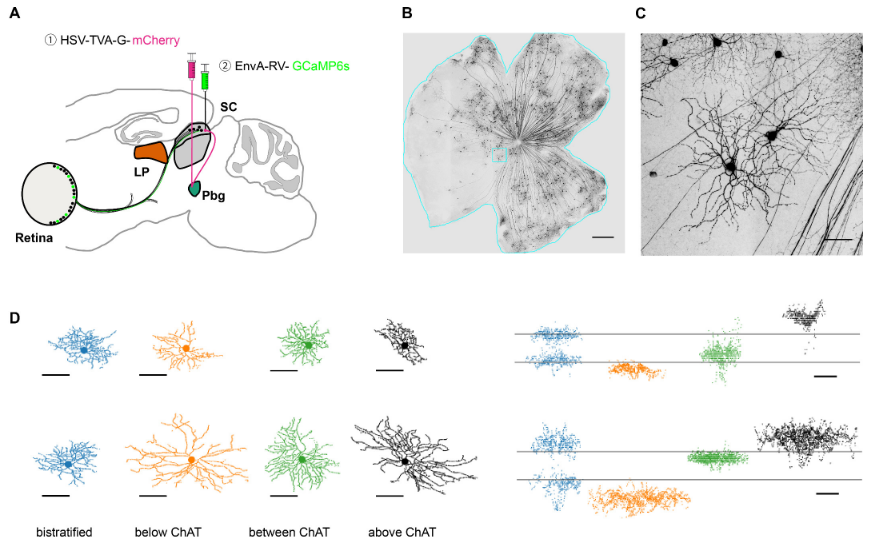

### 1. Data

The data set contains morphological reconstructions of $599$ retinal ganglion cell dendrites with cell type label and projection target to either the parabigeminal (Pbg) or the pulvinar nucleus (LP)([Reinhard et al. (2019)](https://elifesciences.org/articles/50697)). 
Here we only keep cells that map to clusters with more than six cells per cluster which leads to $550$ remaining reconstructions. 

Download the data file `nds_cl_8.zip` from ILIAS and unzip it in a subfolder `../data/`


### 2. Toolbox

We will use MorphoPy (Laturnus, et al., 2020; https://github.com/berenslab/MorphoPy) for this exercise. We recommend to use the Github version, as it is more up-to-date:

```
git clone https://github.com/berenslab/MorphoPy
pip install -e MorphoPy
```

Most of the computations and even some plottings will be handled by MorphoPy. You can learn more about MorphoPy's APIs in this [tutorial](https://nbviewer.jupyter.org/github/berenslab/MorphoPy/blob/master/notebooks/MORPHOPY%20Tutorial.ipynb). 

In [1]:
import pandas as pd
import numpy as np
import os

from morphopy.computation import file_manager
from morphopy.neurontree.plotting import show_threeview
from morphopy.neurontree import NeuronTree as nt

import warnings

warnings.filterwarnings("ignore")

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import glob

%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearnv

Last updated: 2025-06-22 14:16:38CEST

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.21.0

sklearnv: not installed

numpy     : 1.26.2
matplotlib: 3.8.0
morphopy  : 0.7.2
seaborn   : 0.13.0
pandas    : 2.2.3

Watermark: 2.5.0



# Inspect the raw data

#### File format

Morphological reconstructions are typically stored in the SWC file format, a simple text file that holds node information in each row and connects nodes through the `parent` node id. A parent id of -1 indicates no parent, so the starting point of the tree graph, also called the root. 
The `type` label indicates the node type (1: somatic , 2: axonal, 3: dendritic (basal), 4: dendritic (apical), 5+: custom).
The code snippet below loads in one swc file and prints its head. 

You can find a more detailed specification of SWC and SWC+ [here](http://www.neuronland.org/NLMorphologyConverter/MorphologyFormats/SWC/Spec.html) and [here](https://neuroinformatics.nl/swcPlus/).



In [3]:
def load_swc(filepath: str) -> pd.DataFrame:
    """Loads in the swc located at filepath as a pandas dataframe.

    Args:
        filepath (str): The path to the swc file.

    Returns:
        pd.DataFrame: A pandas dataframe containing the swc file.
    """
    swc = pd.read_csv(
        filepath,
        delim_whitespace=True,
        comment="#",
        names=["n", "type", "x", "y", "z", "radius", "parent"],
        index_col=False,
    )
    return swc


# define color for each cluster
colors = sns.color_palette("rainbow_r", n_colors=14)

In [4]:
# import swc file
PATH = "../data/nds_cl_8/"
data_path = PATH + "reconstructions/soma-centered/"
filename = "0006_00535_4L_C02_01.swc"
filepath = data_path + filename

swc = load_swc(filepath)
swc.head()

,n,type,x,y,z,radius,parent
0,1,1,0.00,0.00,0.47,1.0,-1
1,2,3,-0.03,0.00,0.47,1.0,1
2,3,3,0.17,-0.08,0.51,1.0,1
3,4,3,0.24,-0.31,0.38,1.0,3
4,5,3,0.02,0.14,0.42,1.0,1


The labels `x`, `y`, and `z` hold a node's 3D coordinate in tracing space (here in microns). For reasons of simplicity we will work with reconstructions that are soma centered in XY.

The assigned cell type labels are stored in the file `rgc_labels.csv` and indexed by their `Cell_nr`. In this file you find three different cluster assignments: `clusterA` is the assignment of the authors (clus1 -- clus14), `clusterB` is the respective cluster identifier of the [Eyewire museum](http://museum.eyewire.org) (also see [Bae et al. 2018](https://www.sciencedirect.com/science/article/pii/S0092867418305725)), and `clusterC` are molecular or functional label names when available. 
We have formatted the cluster assignments of the authors (`clusterA`) into integer values and stored them in the column `cluster`, which we will use in the following.

In [5]:
labels = pd.read_csv(PATH + "rgc_labels.csv", index_col=0)

cluster_label, cluster_counts = np.unique(labels["cluster"], return_counts=True)
labels.head()

,Cell_nr,projection_site,clusterA,clusterB,clusterC,cluster
1,2,LP,clus6,4ow,tOFFα,6
2,3,LP,clus2,2an,F-mini-OFF,2
3,4,LP,clus1,1wt,sOFFα,1
4,6,LP,clus7,5to,NaN,7
5,7,LP,clus10,6sn,NaN,10


## Task 1: Plotting individual morphologies

Load data using `file_manager` and plot individual morphologie using `show_threeview` of from `MorphoPy`. It plots all three planar views on the reconstruction. 

Here, XY shows the planar view on top of the retina, and Z denotes the location within the inner plexiform layer (IPL).

Noted, by default, the `file_manager` loads data with `pca_rot=True` and `soma_center=True`. For the all the exercise in this Coding Lab, it's better to set both of them as `False`. 

*Grading: 2pts*

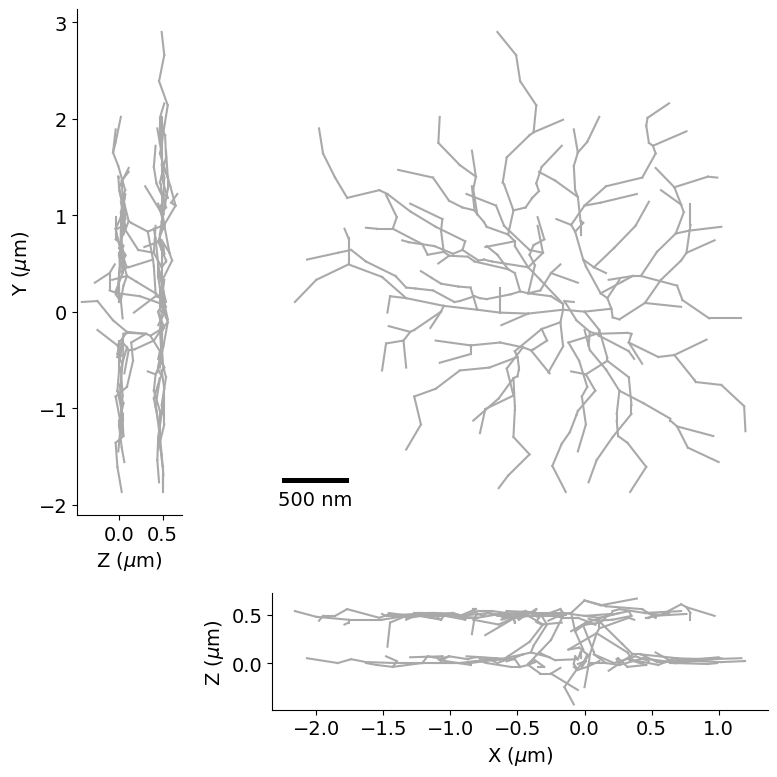

In [6]:
# ----------------------------------------------------------------
# load the example cell "0060_00556_3R_C02_01" with `file_manager`
# from morphology (0.5 pts)
# ----------------------------------------------------------------
from morphopy.computation import file_manager as fm
from morphopy.neurontree.plotting import show_threeview

# build full path to example SWC
example_file = "0060_00556_3R_C02_01.swc"
example_path = os.path.join(data_path, example_file)

# load with pca_rot=False and soma_center=False
nt = fm.load_swc_file(example_path, soma_center=False, pca_rot=False)

# -------------------------------------
# plot all three planar views (0.5 pts)
# -------------------------------------

# plot XY, XZ, YZ views
fig = plt.figure(figsize=(8, 8))
show_threeview(nt, fig)
fig.tight_layout()
plt.show()

### Questions (0.5 pts)

1) Describe the dendritic structure of this neuron. How is it special? Can you even give a technical term for its appearance?

**Answer:** This retinal ganglion cell is bistratified, meaning its dendrites form two distinct, thin arborization bands within the inner plexiform layer (IPL). In the X–Z and Y–Z views you can clearly see two separate lamina of dendritic processes—one in the outer half of the IPL and one in the inner half—rather than a single continuous arbor. Such a “twin‐layer” morphology is characteristic of ON–OFF (or direction‐selective) ganglion cells, which sample inputs in two strata to drive responses at both light onset and offset.

SWC files are a compact way for storing neural morphologies but their graph structure makes them difficult to handle for current machine learning methods. We, therefore, need to convert our reconstructions into a reasonable vector-like representations. 

Here we will present two commonly chosen representations: Morphometric statistics and density maps


In [7]:
# load all reconstructions. Note: files are sorted by cell number
def load_files(path: str) -> list[nt]:
    """Returns list of NeuronTrees for all .swc files in `path`.
    The reconstructions should be sorted ascendingly by their filename.

    Args:
        path (str): The path to the folder containing the reconstructions.

    Returns:
        list[nt]: An object array of NeuronTrees containing all reconstructions at `path`.
    """
    swc_files = sorted(glob.glob(os.path.join(path, "*.swc")))
    neurons = []
    for swc in swc_files:
        nt = fm.load_swc_file(swc, soma_center=False, pca_rot=False)
        neurons.append(nt)
    return neurons


neurons = load_files(data_path)
print("Number of reconstructions: ", len(neurons))

Number of reconstructions:  550


## Task 2: Morphometric statistics

Morphometric statistics denote a set of hand-crafted single valued features such as `soma radius`, `number of tips` or `average branch angle`. For a more detailed explanation of morphometrics please refer to the [MorphoPy documentation](https://github.com/berenslab/MorphoPy#morphometric-statistics).

*Grading: 4pts*

First, let's compute the feature-based representation for each cell using the function `compute_morphometric_statistics` of the MorphoPy package which computes a predefined set of $28$ statistics.


In [8]:
from morphopy.computation.feature_presentation import compute_morphometric_statistics


# --------------------------------------------------------------------------
# 1. extraction the morphometric statistics for the entire data set (0.5 pts)
# --------------------------------------------------------------------------
ms_list = [compute_morphometric_statistics(nt).iloc[0] for nt in neurons]

# stack into an array of shape (n_cells, 28)
ms_matrix = np.vstack(ms_list)
# -----------------------------------------------------------------------------------
# 2. concatenate data into one pd.DataFrame and set the `Cell_nr`` as index (0.5 pts)
# -----------------------------------------------------------------------------------
swc_files = sorted(glob.glob(os.path.join(data_path, "*.swc")))
cell_ids = [os.path.splitext(os.path.basename(f))[0] for f in swc_files]

morphometric_statistics = pd.DataFrame(ms_list, index=cell_ids)
morphometric_statistics.index.name = "Cell_nr"

# preview the first few rows
morphometric_statistics.head()

,branch_points,width,depth,height,tips,stems,total_length,avg_thickness,max_thickness,total_surface,...,median_intermediate_segment_pl,median_terminal_segment_pl,log_max_tortuosity,log_min_tortuosity,log_median_tortuosity,max_branch_angle,min_branch_angle,mean_branch_angle,max_degree,tree_asymmetry
Cell_nr,,,,,,,,,,,,,,,,,,,,,
0002_00535_4L_C01_01,66.0,4.12,5.96,0.54,69.0,3.0,65.793587,1.0,1.0,413.393297,...,0.334798,0.456196,0.253612,0.0,0.005766,124.974479,7.286952,50.402105,3.0,0.726199
0003_00535_1L_C02_01,18.0,3.07,2.66,0.68,23.0,1.0,18.657365,1.0,1.0,117.227681,...,0.345014,0.349991,0.285133,0.0,0.000564,110.367090,18.036960,57.088068,3.0,0.738502
0004_00535_1R_C01_01,54.0,5.05,3.53,0.72,61.0,6.0,41.349847,1.0,1.0,259.808753,...,0.202111,0.281069,0.312270,0.0,0.000000,131.508679,25.596621,59.646776,3.0,0.706943
0006_00535_4L_C02_01,36.0,3.45,4.38,0.49,39.0,4.0,32.249580,1.0,1.0,202.630089,...,0.217084,0.412995,0.251400,0.0,0.017747,130.034126,16.436535,54.683803,2.0,0.601296
0007_00535_4L_C03_01,31.0,4.13,3.86,0.58,40.0,7.0,34.647295,1.0,1.0,217.695372,...,0.248395,0.530086,0.217363,0.0,0.024678,104.036243,2.970445,55.498150,3.0,0.579942


Now let's visualize the data.

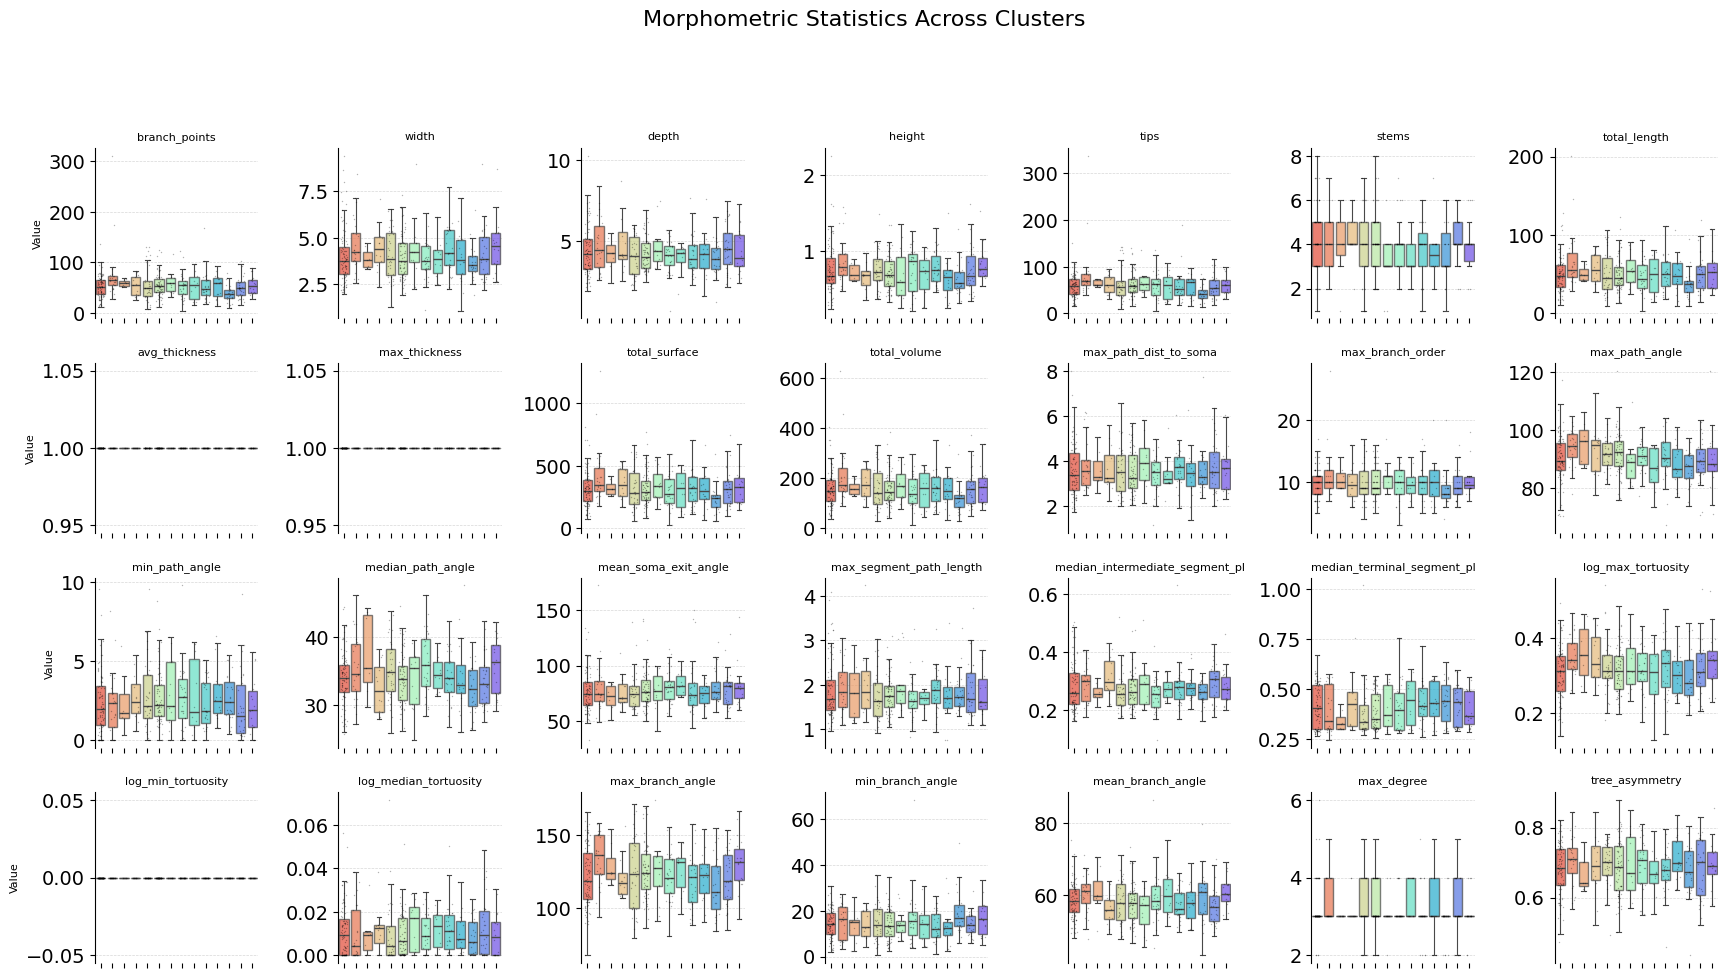

In [9]:
# -----------------------------------------------------------
# Create a scatter/strip plot for each morphometric statistic
# showing how it varies across clusters. (2 pts)
# -----------------------------------------------------------
# 1) Prepare the stats DataFrame with cluster labels
df_stats = morphometric_statistics.reset_index().rename(columns={"index": "Cell_nr"})
df_stats["cluster"] = (
    df_stats["Cell_nr"]
    .str[:4]  # extract "0006" → int 6
    .astype(int)
    .map(labels["cluster"])
)
df_stats = df_stats.dropna(subset=["cluster"])

# 2) Melt to long format for faceting
features = morphometric_statistics.columns.tolist()
df_long = df_stats.melt(
    id_vars=["Cell_nr", "cluster"],
    value_vars=features,
    var_name="feature",
    value_name="value",
)

# 3) Build the FacetGrid
n_cols = 7
g = sns.FacetGrid(
    df_long, col="feature", col_wrap=n_cols, sharey=False, height=2.5, aspect=1
)

# 4) Draw boxplots (without fliers) and overlay stripplots
g.map_dataframe(
    sns.boxplot,
    x="cluster",
    y="value",
    palette=colors,
    fliersize=0,
    boxprops={"alpha": 0.7, "linewidth": 1},
    whiskerprops={"linewidth": 0.8},
    capprops={"linewidth": 0.8},
)
g.map_dataframe(
    sns.stripplot, x="cluster", y="value", color="k", size=1, jitter=0.25, alpha=0.3
)

# 5) Tidy up each axis
axes = g.axes.flatten() if hasattr(g.axes, "flatten") else g.axes
for idx, ax in enumerate(axes):
    # Rotate and shrink x-tick labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=6)
    # Only leftmost column gets a y-label
    if (idx % n_cols) == 0:
        ax.set_ylabel("Value", fontsize=8)
    else:
        ax.set_ylabel("")
    # Remove x-axis label (we rely on tick labels)
    ax.set_xlabel("")
    # Light horizontal gridlines
    ax.yaxis.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
    sns.despine(ax=ax, left=False, bottom=True)

# 6) Titles and layout
g.set_titles("{col_name}", size=8)
g.fig.subplots_adjust(top=0.92, hspace=0.5, wspace=0.3)
g.fig.suptitle("Morphometric Statistics Across Clusters", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

### Questions (1 pt)

1) Which statistics separate clusters well? Which can be removed? (tips: there are 5 uninformative features)

**Answer:**

- **Good separators**  
  - **Branching complexity**: `branch_points`, `tips`, `stems`  
  - **Size metrics**: `total_length`, `total_surface`, `total_volume`  
  - **Branch‐angle statistics**: `max_path_angle`, `median_path_angle`, `mean_branch_angle`  

- **Uninformative features (drop these 5)**  
  1. `avg_thickness`  
  2. `max_thickness`  
  3. `log_min_tortuosity`  
  4. `max_degree`  
  5. `min_path_angle` (near‐complete overlap across clusters)  

2) More generally, what do morphometric statistics capture well? What are their advantages, what might be their downsides? Briefly explain.

**Answer:**

- **Pros**  
  - **Interpretable**: each feature (e.g. “total_length”, “branch_points”) has a clear biological meaning.  
  - **Fixed-length vector**: yields a compact 28-dimensional representation, ready for PCA, clustering, or classification.  
  - **Fast to compute**: hand-crafted metrics run in milliseconds, even on large datasets.  

- **Cons**  
  - **Lossy compression**: collapsing a full 3D arbor into a few scalars can miss laminar patterns or local motifs.  
  - **Limited vocabulary**: you only capture pre-defined features, so novel or subtle shape differences may be overlooked.  
  - **Scale mismatch**: metrics range from sub-micron angles to hundreds of microns in length, requiring careful normalization or grouping for joint analysis.  

## Task 3: Density maps

Density maps project a neuron's 3D point cloud ($x$, $y$, $z$) onto a plane or an axis, and bin the projected point cloud into a fixed number of bins. Hereby, the binning controls how much global or local information is kept, which majorly affects the results.

**Exercise:** Compute the density maps of all neurons onto all cardinal planes and axes using the method `compute_density_maps`. You can manipulate the parameters for the density maps via the dictonary `config`. 
Make sure that you normalize the density maps globally and bin each direction into $20$ bins.
You are welcome to explore, how the different projections look like but we will only use the z-projection for further analysis.


Possible parameters to pass are:

- `distance`: (default=1, in microns) determines the resampling distance.
- `bin_size`: (default=20, in microns). If set the number of bins will be computed such that one bin 
spans `bin_size` microns. This is overwritten when `n_bins_x/y/z` is set!
- `n_bins_x/y/z`: (default=None) specifies the number of bins for each dimension. If set it will overwrite the 
`bin_size` flag.
- `density`: (default=True) bool to specify if a density or counts are returned.
- `smooth`: (default=True) bool to trigger Gaussian smoothing.
- `sigma`: (default=1) determines std of the Gaussian used for smoothing. The bigger the sigma the more smoothing occurs. If smooth is set to False this parameter is ignored. 
- `r_min_x/y/z`: (in microns) minimum range for binning of x, y, and z. This value will correspond to the 
minimal histogram edge. 
- `r_max_x/y/z`: (in microns) maximum range for binning for x, y, and z. This value will correspond to the 
maximal histogram edge. 

*Grading: 4pts*

In [10]:
# For further analysis we will remove uninformative features and z-score along each statistic
features_to_drop = [
    "avg_thickness",
    "max_thickness",
    "total_surface",
    "total_volume",
    "log_min_tortuosity",
]
morphometric_data = morphometric_statistics.drop(features_to_drop, axis=1)

# z-score morphometrics and remove nans and uninformative features
morphometric_data = (
    morphometric_data - morphometric_data.mean()
) / morphometric_data.std()
morphometric_data[morphometric_data.isna()] = 0
morphometric_data = morphometric_data.values

In [11]:
# ------------------------------------------------------------------------------------
# Find the minimal and maximal x,y,z - coordinates of the reconstructions to normalize
# the density maps globally using r_min_x/y/z and r_max_x/y/z and print them  for
# each direction. (1 pt)
# ------------------------------------------------------------------------------------

# get list of all SWC files (same order as `neurons`)
swc_files = sorted(glob.glob(os.path.join(data_path, "*.swc")))

# accumulate all xyz‐coordinates
coords = []
for fn in swc_files:
    df = load_swc(fn)
    coords.append(df[["x", "y", "z"]].values)
coords = np.vstack(coords)

# compute global minima/maxima
r_min_x, r_min_y, r_min_z = coords.min(axis=0)
r_max_x, r_max_y, r_max_z = coords.max(axis=0)

print(f"x: {r_min_x:.2f} → {r_max_x:.2f}")
print(f"y: {r_min_y:.2f} → {r_max_y:.2f}")
print(f"z: {r_min_z:.2f} → {r_max_z:.2f}")

x: -6.34 → 5.14
y: -5.49 → 5.36
z: -1.50 → 1.86


In [12]:
from morphopy.computation.feature_presentation import compute_density_maps


# ---------------------------------------------------------------------------------
# complete the config dict and compute the z-density maps for each neuron (1 pts)
# ---------------------------------------------------------------------------------
config_global = dict(
    distance=1.0,  # μm resampling
    n_bins_x=20,
    n_bins_y=20,
    n_bins_z=20,
    density=True,  # return normalized density
    smooth=True,  # apply Gaussian smoothing
    sigma=1.0,  # smoothing σ
    r_min_x=r_min_x,
    r_min_y=r_min_y,
    r_min_z=r_min_z,
    r_max_x=r_max_x,
    r_max_y=r_max_y,
    r_max_z=r_max_z,
)

# Compute density map dict for each neuron
density_maps = [
    compute_density_maps(neurontree=neuron, config_params=config_global)
    for neuron in neurons
]


# extract the z density map
dm_z = np.array([density_map["z_proj"]["data"] for density_map in density_maps])
dm_z.shape

(550, 20)

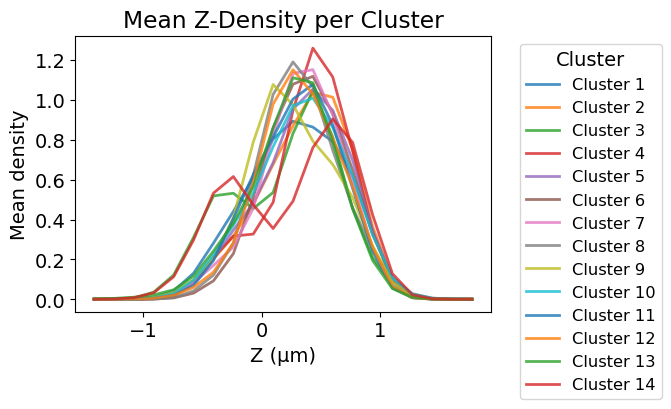

In [17]:
# --------------------------------------------------------------------
# plot the Z-density maps and their means sorted by class label (1 pt)
# Note: make sure the clusters are comparable.
# --------------------------------------------------------------------

# Build DataFrame of z-densities
swc_basenames = [os.path.splitext(os.path.basename(f))[0] for f in swc_files]
z_edges = np.linspace(r_min_z, r_max_z, config_global["n_bins_z"] + 1)
z_centers = (z_edges[:-1] + z_edges[1:]) / 2

df_z = pd.DataFrame(dm_z, index=swc_basenames, columns=z_centers)

# Attach cluster labels
df_z["cell_int"] = df_z.index.str[:4].astype(int)
df_z["cluster"] = df_z["cell_int"].map(labels["cluster"])
df_z = df_z.sort_values("cluster").drop(columns="cell_int")

# Plot mean z-density per cluster
plt.figure(figsize=(7, 4))

# get sorted list of clusters (excluding NaN)
cluster_ids = sorted(df_z["cluster"].dropna().unique())

for cl in cluster_ids:
    mean_curve = df_z[df_z["cluster"] == cl].drop(columns="cluster").mean(axis=0)
    plt.plot(
        z_centers,
        mean_curve,
        label=f"Cluster {int(cl)}",
        linewidth=2,
        alpha=0.8,
    )

plt.legend(
    title="Cluster",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    fontsize="small",
)
plt.xlabel("Z (µm)")
plt.ylabel("Mean density")
plt.title("Mean Z-Density per Cluster")
plt.tight_layout()
plt.show()

### Questions (1 pt)

1) What does the Z-density map tell you about the cell types? Can you identify a trend in the density maps?

**Answer:**
The Z-density map shows how the neuron's processes are distributed along the Z-axis, which corresponds to depth within the retina’s inner plexiform layer (IPL). Different clusters have distinct Z-density profiles: some are centered at different depths, some are broader or more narrowly stratified, and some are more asymmetric. This indicates that different cell types project their dendrites to specific sublayers within the IPL, consistent with their known functional specializations. A clear trend is that some clusters are more monostratified (sharp, narrow peak), while others are bistratified or have a broader spread, reflecting their different integration properties.


2) Which cluster(s) would you expect the cell from Task 1 to come from and why?

**Answer:**
The cell from Task 1 had a very clear bistratified dendritic structure—its branches were concentrated in two separate bands along the Z-axis. Based on the Z-density cluster means, this pattern would most likely correspond to clusters whose mean Z-density profile is bimodal or shows two distinct peaks (rather than a single sharp peak). Therefore, I would expect the Task 1 cell to come from one of the clusters whose Z-density is broad or clearly split into two layers, likely those with a more complex or bistratified mean Z-density profile. The exact cluster(s) can be confirmed by matching the density profile to the mean lines shown in the plot.


## Task 4: 2D embedding using t-SNE


Embed both data, the morphometric statistics and the density maps, in 2D using t-SNE and color each embedded point by its cluster assignment.

*Grading: 3 pts*

In [21]:
from openTSNE import TSNE

# ----------------------------------------------------------------------
# Fit t-SNE with morphometric statistics and density maps (0.5 + 0.5 pt)
# Note that this can take a bit to run. (use perplexity=100
# and a random state of 17)
# ----------------------------------------------------------------------


# Set up t-SNE with desired parameters
tsne = TSNE(
    n_components=2,
    perplexity=100,
    random_state=17,
    n_iter=2000,
    metric="euclidean",
    early_exaggeration=12,
    learning_rate=500,
    initialization="pca",
)

# Fit t-SNE embeddings (this will take a moment)
tsne_morpho = tsne.fit(morphometric_data)
tsne_density = tsne.fit(dm_z)

In [23]:
tsne_density.shape, tsne_morpho.shape

((550, 2), (550, 2))

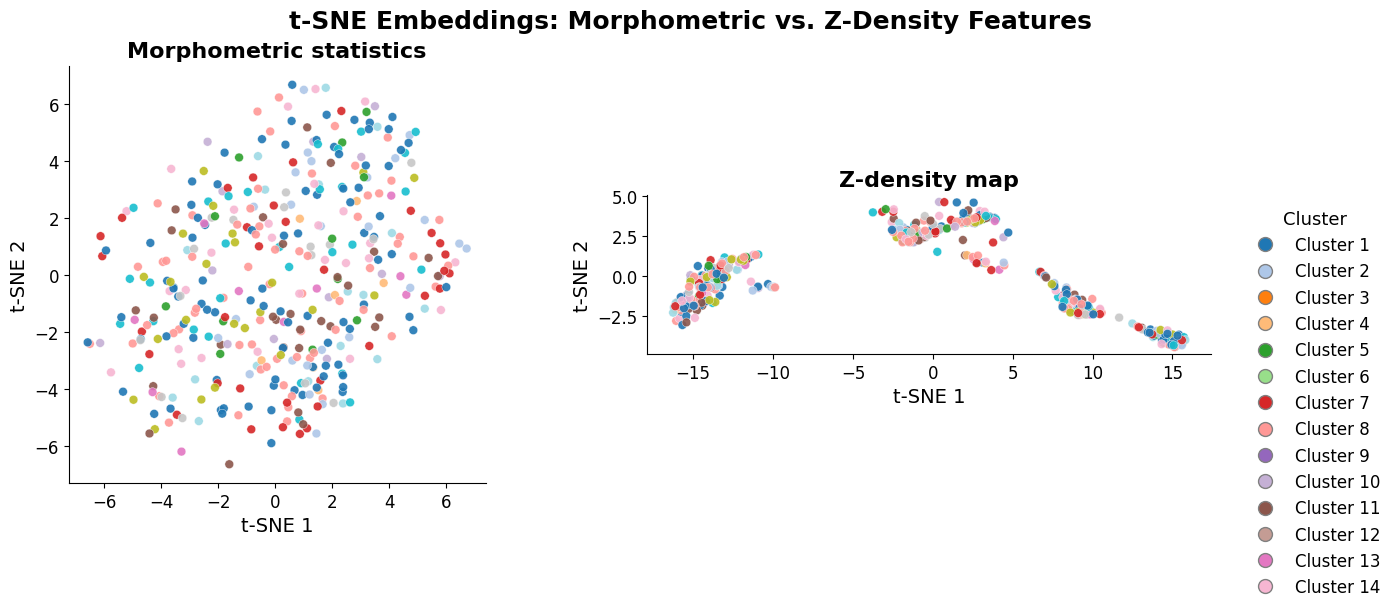

In [24]:
# ----------------------------------------------------------------------------
# plot tsne fits for both morpometric statistics and z-projected density maps.
# Color the points appropriately and answer the questions below. (2 pt)
# ----------------------------------------------------------------------------


# 1) Reconstruct the list of cell IDs in the same order:
swc_files = sorted(glob.glob(os.path.join(data_path, "*.swc")))
cell_ids = [os.path.splitext(os.path.basename(f))[0] for f in swc_files]

# 2) Extract the integer cell number from the filename, map to the 'cluster' column:
cell_ints = [int(cid[:4]) for cid in cell_ids]
cluster_series = pd.Series(cell_ints).map(labels["cluster"])

# 3) Build a boolean mask of only those with valid (non-NaN) cluster labels:
valid_mask = cluster_series.notna().values
clusters = cluster_series[valid_mask].astype(int).values

# 4) Filter the two embeddings to exactly those same cells:
emb_morpho = tsne_morpho[valid_mask]
emb_density = tsne_density[valid_mask]

# 5) Prepare colors:
unique_clusters = sorted(np.unique(clusters))
palette = sns.color_palette("tab20", n_colors=len(unique_clusters))
cluster_to_idx = {cl: i for i, cl in enumerate(unique_clusters)}
cluster_indices = np.array([cluster_to_idx[cl] for cl in clusters])

# 6) Plot side by side:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)
titles = ["Morphometric statistics", "Z-density map"]
embeddings = [emb_morpho, emb_density]

for ax, emb, title in zip(axes, embeddings, titles):
    ax.scatter(
        emb[:, 0],
        emb[:, 1],
        c=cluster_indices,
        cmap="tab20",
        s=40,
        edgecolor="w",
        linewidth=0.3,
        alpha=0.9,
    )
    ax.set_title(title, fontsize=16, weight="bold")
    ax.set_xlabel("t-SNE 1", fontsize=14)
    ax.set_ylabel("t-SNE 2", fontsize=14)
    ax.tick_params(labelsize=12)
    ax.set_aspect("equal")

# 7) Legend:
handles = [
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label=f"Cluster {cl}",
        markerfacecolor=palette[i],
        markersize=10,
        markeredgecolor="gray",
        linewidth=0,
    )
    for i, cl in enumerate(unique_clusters)
]
axes[-1].legend(
    handles=handles,
    title="Cluster",
    title_fontsize="13",
    fontsize="12",
    bbox_to_anchor=(1.04, 1),
    loc="upper left",
    frameon=False,
)

sns.despine()
fig.suptitle(
    "t-SNE Embeddings: Morphometric vs. Z-Density Features", fontsize=18, weight="bold"
)
plt.show()

### Questions:
1) Which representation produces the better clustering? Why could this be the case?

**Answer:**
The Z-density maps clearly produce better clustering than the morphometric statistics. In the t-SNE embedding, cells with similar laminar profiles form tight “islands” along the first axis, whereas the morphometric‐only embedding remains a diffuse cloud with heavy overlap between clusters. This happens because the density maps retain the full spatial distribution of the arbor (how dendritic mass is stratified along Z), capturing subtle laminar patterns that hand‐crafted scalars (like total length or branch count) cannot represent.


2) What are the advantages of morphometric statistics over density maps 

**Answer:**
- **Interpretability:** each metric (e.g. `branch_points`, `total_length`) has a clear biological meaning.  
- **Compactness:** yields a fixed-length, low-dimensional vector (e.g. 28 features), ready for standard ML workflows.  
- **Speed & simplicity:** very fast to compute and easy to normalize, without having to tune smoothing or binning parameters.  
- **Data efficiency:** works well even with small sample sizes—no need to learn from high-dimensional histograms.


3) What are the advantages of density maps over morphometric statistics 

**Answer:**
- **Rich spatial detail:** preserve the full 1D (or 2D) distribution of the arbor, including multilayer stratification and local motifs.  
- **Fewer hyperparameters in feature engineering:** once you choose bin counts and smoothing, you capture all geometry without hand-selecting tens of metrics.  
- **Compatibility with modern models:** can be fed into convolutional or graph‐based neural networks to learn features directly from the density grid.  
- **Better separability:** as we saw, cells with distinct laminar profiles naturally cluster apart, improving downstream classification or clustering.  

## Task 5: Predicting the projection site

The relationship between neuronal morphology and functional specialization is well-established in neurobiology. Hence, we expect distinct functional domains within the thalamus to exhibit corresponding morphological signatures. In this analysis, we aim to predict the thalamic projection site (`labels['projection_site']`) of individual neurons based on their morphological characteristics. Fit a logistic regression on both morphological representations and report its average cross validated (cv=5) prediction accuracy for each. Which representation works better to recover the prediction target? Which features are most relevant for that prediction?

You can use `LogisticRegressionCV` of the scikit-learn library directly. To understand the relevance of individual features plot the fitted linear coefficients. Note, since the classes are imbalanced make sure to report the balanced prediction accuracy.

*Grading: 2 pts*

In [35]:
from sklearn.linear_model import LogisticRegressionCV


# -----------------------------------------------------------------------------
# Fit a logistic regressor to predict the projection site based on both feature
# representations and print the avg. prediction accuracy (1 pt)
# -----------------------------------------------------------------------------


## 1) Reconstruct file order and extract the leading cell number
swc_files = sorted(glob.glob(os.path.join(data_path, "*.swc")))
cell_ids = [os.path.splitext(os.path.basename(f))[0] for f in swc_files]
cell_nums = [int(cid.split("_")[0]) for cid in cell_ids]

# 2) Align projection_site labels and drop any missing
proj_ser = labels["projection_site"].reindex(cell_nums)
mask = proj_ser.notna().values
y = proj_ser[mask].values

# 3) Filter feature matrices to only those cells
X_morpho = morphometric_data[mask]
X_density = dm_z[mask]

# 4) Set up a CV‐wrapped logistic regressor
lr_cv = LogisticRegressionCV(
    cv=5,
    scoring="balanced_accuracy",
    class_weight="balanced",
    max_iter=5000,
    random_state=17,
)

# 5) Compute and print mean balanced‐accuracy
acc_m = cross_val_score(lr_cv, X_morpho, y, cv=5, scoring="balanced_accuracy").mean()
acc_d = cross_val_score(lr_cv, X_density, y, cv=5, scoring="balanced_accuracy").mean()

print(f"Balanced CV accuracy (morphometric stats): {acc_m:.3f}")
print(f"Balanced CV accuracy (z-density map):      {acc_d:.3f}")

Balanced CV accuracy (morphometric stats): 0.467
Balanced CV accuracy (z-density map):      0.537


While Z density maps allow for better recovery of cell type labels, they are worse than morphometric statistics on predicting the projection target. 

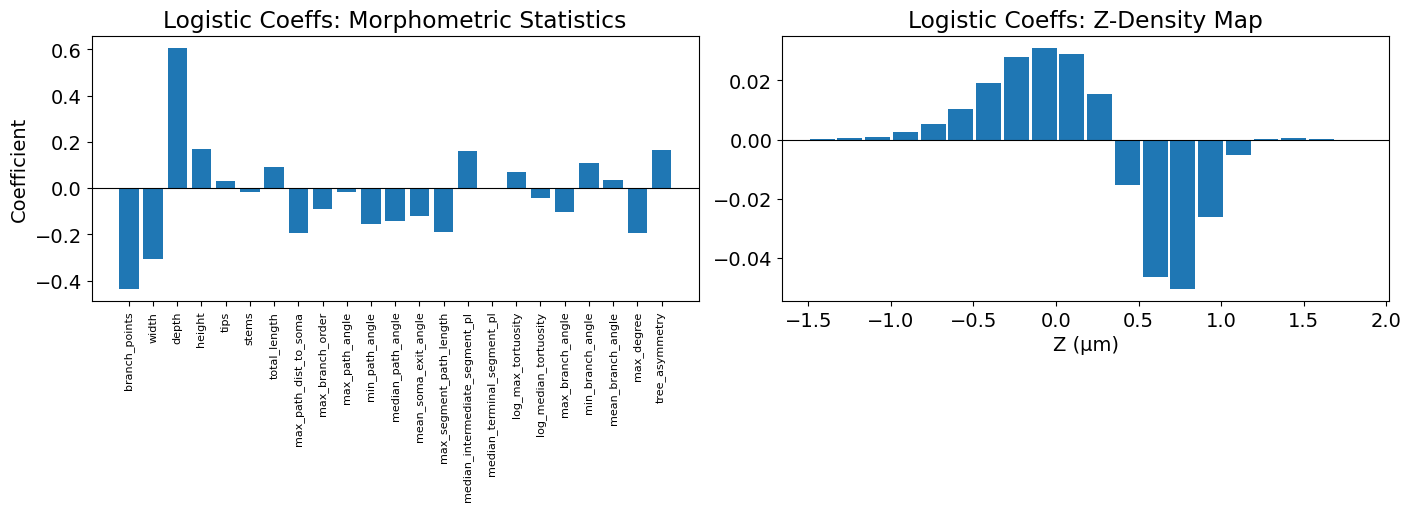

In [36]:
# ---------------------------------------------------------------------------
# Plot the fitted linear coefficients for both of the feature representations
# and answer the question below. (1 pt)
# ---------------------------------------------------------------------------

# Cell 2: Refit on full data and plot the learned coefficients
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV

# Refit LR‐CV on the entire valid set to get final coefficients
lr_m_final = LogisticRegressionCV(
    cv=5,
    scoring="balanced_accuracy",
    class_weight="balanced",
    max_iter=5000,
    random_state=17,
).fit(X_morpho, y)

lr_d_final = LogisticRegressionCV(
    cv=5,
    scoring="balanced_accuracy",
    class_weight="balanced",
    max_iter=5000,
    random_state=17,
).fit(X_density, y)

# 2) Extract coefficient arrays
coef_m = lr_m_final.coef_.ravel()
coef_d = lr_d_final.coef_.ravel()

# 3) Prepare feature‐name labels
feat_m = morphometric_statistics.drop(features_to_drop, axis=1).columns.tolist()
z_edges = np.linspace(r_min_z, r_max_z, config_global["n_bins_z"] + 1)
z_centers = (z_edges[:-1] + z_edges[1:]) / 2

# 4) Plot side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

# Morphometric‐feature coefficients
ax1.bar(range(len(feat_m)), coef_m)
ax1.axhline(0, color="k", linewidth=0.8)
ax1.set_xticks(range(len(feat_m)))
ax1.set_xticklabels(feat_m, rotation=90, fontsize=8)
ax1.set_title("Logistic Coeffs: Morphometric Statistics")
ax1.set_ylabel("Coefficient")

# Z‐density‐feature coefficients
width = z_centers[1] - z_centers[0]
ax2.bar(z_centers, coef_d, width=width * 0.9)
ax2.axhline(0, color="k", linewidth=0.8)
ax2.set_xlabel("Z (µm)")
ax2.set_title("Logistic Coeffs: Z-Density Map")

plt.show()

### Question:

1) Which morphometrics are informative on the projection site?

**Answer:**
Looking at the bar chart of the fitted morphometric coefficients, the features with the largest absolute weights (i.e. most informative) are:

- **`width`** (strong positive weight)  
- **`branch_points`** (strong negative weight)  
- **`height`** (moderate positive weight)  
- **`tree_asymmetry`** (moderate positive weight)  
- **`max_path_dist_to_soma`** (moderate negative weight)  

In other words, cells that project to one thalamic target tend to be wider and more asymmetric (fewer branch points and shorter maximum path‐lengths), whereas the opposite morphology favors the other projection site.

## Further references

Other ways to represent and compare morphologies are
* Persistence: [Description](https://link.springer.com/article/10.1007/s12021-017-9341-1) and [application on somatosensory pyramidal cell dendrites](https://academic.oup.com/cercor/article/29/4/1719/5304727) by Kanari et al. 2018

* Tree edit distance: [Heumann et al. 2009](https://link.springer.com/article/10.1007/s12021-009-9051-4)

* Sequential encoding inspired by BLAST: [Encoding](https://link.springer.com/article/10.1186/s12859-015-0604-2) and [similarity analysis on cortical dendrites](https://link.springer.com/article/10.1186/s12859-015-0605-1) by Gilette et al. 2015

* Vector point clouds: [BlastNeuron: Wan et al. 2015](https://link.springer.com/article/10.1007/s12021-015-9272-7)